# Credit Card Fraud Detection

Dataset retrieved from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

The dataset is collected from European cardholders over the course of two days in September 2013. It contains 284,807 rows and is classified as either fraud or not fraud. There are 31 features in the set, and 28 of the features have all been transformed using principal component analysis. The only 2 features that have not been manipulated are "Time" and "Amount". The "Time" feature contains the seconds elapsed between each transaction and the first transaction in the dataset. The "Amount" feature is the total cost charged on the card for that sample transaction. The final feature in the set is "Class", and this is the determination of whether the sample transaction was fraud or not. This will become our target value that we will be predicting.

The large issue with this dataset is that it is extremely skewed. Out of the 284,807 samples, only 492 are fraudulent.

In [48]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

# numpy, matplotlib, seaborn
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

The data is already very well transformed.

In [49]:
data = pd.read_csv('../../creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [50]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

As you can visually see, the dataset is very skewed. If the data is run through a model without being stratified, it will cause us to get improper accuracy results, as over 99% of the data is not fraudulent.

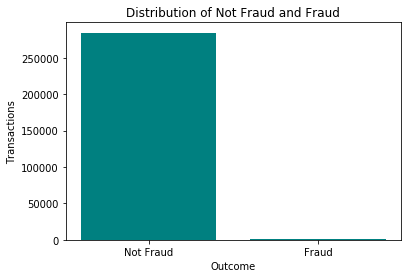

In [51]:
y_class = ['Not Fraud', 'Fraud']

plt.bar(y_class, [np.sum(data['Class'] == 0), np.sum(data['Class'] == 1)], color='teal')
plt.xlabel("Outcome")
plt.ylabel("Transactions")
plt.title("Distribution of Not Fraud and Fraud")
plt.show()

Grab 1,000 rows of non fraudulent transactions and all 492 the occurances of fraudulent transactions. Then we remove the target from the samples and assign them to the target specific variables.

In [56]:
X_not_fraud, X_fraud = data[data.Class == 0][:1000], data[data.Class == 1]
y_not_fraud, y_fraud = X_not_fraud.pop('Class'), X_fraud.pop('Class')

Divide up the data into training and test sets. The training set has 800 non fraudulent samples and 300 fraudulent samples. The test set has 200 non fraudulent sameples and 192 fraudulent samples

In [65]:
X_train, y_train = X_not_fraud[:800].append(X_fraud[:300]), y_not_fraud[:800].append(y_fraud[:300])
X_test, y_test = X_not_fraud[800:].append(X_fraud[300:]), y_not_fraud[800:].append(y_fraud[300:])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100)

rnd_params = [
   { 
     'max_depth': [12, 14, 16, 18, 20, 22, 24, 26, 28], 
     'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
     'max_leaf_nodes': [4, 8, 12, 16, 20, 24, 28],
   },
]

rnd_cv = GridSearchCV(estimator=rnd_clf, param_grid=rnd_params, cv=4)
rnd_cv.fit(X_train, y_train)